In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression

# import warnings
# warnings.filterwarnings('ignore')

In [7]:
df = pd.read_csv('sphist.csv')

df.head()

,Date,Open,High,Low,Close,Volume,Adj Close
0,2015-12-07,2090.419922,2090.419922,2066.780029,2077.070068,4.043820e+09,2077.070068
1,2015-12-04,2051.239990,2093.840088,2051.239990,2091.689941,4.214910e+09,2091.689941
2,2015-12-03,2080.709961,2085.000000,2042.349976,2049.620117,4.306490e+09,2049.620117
3,2015-12-02,2101.709961,2104.270020,2077.110107,2079.510010,3.950640e+09,2079.510010
4,2015-12-01,2082.929932,2103.370117,2082.929932,2102.629883,3.712120e+09,2102.629883


In [8]:
df.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Volume       float64
Adj Close    float64
dtype: object

In [9]:
df["Date"] = pd.to_datetime(df["Date"])

df.dtypes

Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Volume              float64
Adj Close           float64
dtype: object

In [10]:
# Sort data in descending order

df = df.sort_values(by='Date')

df.head()

,Date,Open,High,Low,Close,Volume,Adj Close
16589,1950-01-03,16.66,16.66,16.66,16.66,1260000.0,16.66
16588,1950-01-04,16.85,16.85,16.85,16.85,1890000.0,16.85
16587,1950-01-05,16.93,16.93,16.93,16.93,2550000.0,16.93
16586,1950-01-06,16.98,16.98,16.98,16.98,2010000.0,16.98
16585,1950-01-09,17.08,17.08,17.08,17.08,2520000.0,17.08


## Generating Indicators to assist in making accurate predictions

In [12]:
# def generate_indicator(df, indicator_name, num_days, col, function):
    
#     indicator = df['col'].rolling.function().shift()
    
#     df[indicator_name] = indicator
    
#     return df

# df = generate_indicator(df, 'mean_close_5', 5, 'Close', mean)

# df.head(10)

NameError: name 'mean' is not defined

In [13]:
# Average price of the past 5, 30 and 365 days
day_5 = df["Close"].rolling(5).mean().shift(1)
day_30 = df["Close"].rolling(30).mean().shift(1)
day_365 = df["Close"].rolling(365).mean().shift(1)

# Ratio of the past 5 to 365 days
ratio_5_to_365 = day_5 / day_365

# Standard deviation of the past 5 and 365 days
day_5_std = df["Close"].rolling(5).std().shift(1)
day_365_std = df["Close"].rolling(365).std().shift(1)

# Ratio of the standard deviation of the past 5 to 365 days
ratio_std_5_to_365 = day_5_std / day_365_std

# Add to main dataframe

df['day_5'] = day_5
df['day_30'] = day_30
df['day_365'] = day_365
df['ratio_5_to_365'] = ratio_5_to_365
df['day_5_std'] = day_5_std
df['day_365_std'] = day_365_std
df['ratio_std_5_to_365'] = ratio_std_5_to_365

In [14]:
df.head(10)

,Date,Open,High,Low,Close,Volume,Adj Close,day_5,day_30,day_365,ratio_5_to_365,day_5_std,day_365_std,ratio_std_5_to_365
16589,1950-01-03,16.660000,16.660000,16.660000,16.660000,1260000.0,16.660000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16588,1950-01-04,16.850000,16.850000,16.850000,16.850000,1890000.0,16.850000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16587,1950-01-05,16.930000,16.930000,16.930000,16.930000,2550000.0,16.930000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16586,1950-01-06,16.980000,16.980000,16.980000,16.980000,2010000.0,16.980000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16585,1950-01-09,17.080000,17.080000,17.080000,17.080000,2520000.0,17.080000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16584,1950-01-10,17.030001,17.030001,17.030001,17.030001,2160000.0,17.030001,16.900,NaN,NaN,NaN,0.157956,NaN,NaN
16583,1950-01-11,17.090000,17.090000,17.090000,17.090000,2630000.0,17.090000,16.974,NaN,NaN,NaN,0.089051,NaN,NaN
16582,1950-01-12,16.760000,16.760000,16.760000,16.760000,2970000.0,16.760000,17.022,NaN,NaN,NaN,0.067602,NaN,NaN
16581,1950-01-13,16.670000,16.670000,16.670000,16.670000,3330000.0,16.670000,16.988,NaN,NaN,NaN,0.134796,NaN,NaN
16580,1950-01-16,16.719999,16.719999,16.719999,16.719999,1460000.0,16.719999,16.926,NaN,NaN,NaN,0.196545,NaN,NaN


In [15]:
# Drop rows with missing values (NaN)
df = df.dropna(axis=0)

In [16]:
df.head(10)

,Date,Open,High,Low,Close,Volume,Adj Close,day_5,day_30,day_365,ratio_5_to_365,day_5_std,day_365_std,ratio_std_5_to_365
16224,1951-06-19,22.020000,22.020000,22.020000,22.020000,1100000.0,22.020000,21.800,21.703333,19.447726,1.120954,0.256223,1.790253,0.143121
16223,1951-06-20,21.910000,21.910000,21.910000,21.910000,1120000.0,21.910000,21.900,21.683000,19.462411,1.125246,0.213659,1.789307,0.119409
16222,1951-06-21,21.780001,21.780001,21.780001,21.780001,1100000.0,21.780001,21.972,21.659667,19.476274,1.128142,0.092574,1.788613,0.051758
16221,1951-06-22,21.549999,21.549999,21.549999,21.549999,1340000.0,21.549999,21.960,21.631000,19.489562,1.126757,0.115108,1.787659,0.064390
16220,1951-06-25,21.290001,21.290001,21.290001,21.290001,2440000.0,21.290001,21.862,21.599000,19.502082,1.121008,0.204132,1.786038,0.114293
16219,1951-06-26,21.299999,21.299999,21.299999,21.299999,1260000.0,21.299999,21.710,21.564333,19.513617,1.112556,0.292831,1.783946,0.164148
16218,1951-06-27,21.370001,21.370001,21.370001,21.370001,1360000.0,21.370001,21.566,21.535000,19.525315,1.104515,0.278980,1.781613,0.156589
16217,1951-06-28,21.100000,21.100000,21.100000,21.100000,1940000.0,21.100000,21.458,21.522000,19.537041,1.098324,0.208015,1.779624,0.116887
16216,1951-06-29,20.959999,20.959999,20.959999,20.959999,1730000.0,20.959999,21.322,21.502333,19.548932,1.090699,0.162080,1.775513,0.091286
16215,1951-07-02,21.100000,21.100000,21.100000,21.100000,1350000.0,21.100000,21.204,21.470667,19.560685,1.084011,0.169205,1.770595,0.095564


365 rows were removed.

## Training the Algorithm

In [19]:
# Split into test and training dataset

train = df[df["Date"] < datetime(year=2013, month=1, day=1)]
test = df[df["Date"] >= datetime(year=2013, month=1, day=1)]

# print(train.head())

# test.head()

In [20]:
features = ['day_5', 'day_30', 'day_365', 'ratio_5_to_365', 'day_5_std', 'day_365_std', 'ratio_std_5_to_365']

lr = LinearRegression()

lr.fit(train[features], train['Close'])

predictions = lr.predict(test[features])

mae = mean_absolute_error(test['Close'], predictions)

mse = mean_squared_error(test['Close'], predictions)
rmse = np.sqrt(mse)

print(mae)
print(rmse)

16.145140609743716
22.201870066394005


In [21]:
print(test.shape)

(739, 14)


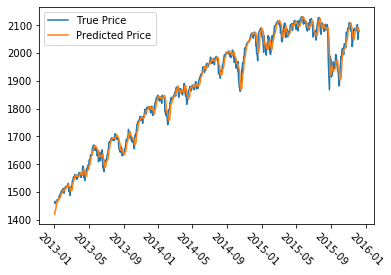

In [24]:
plt.plot(test['Date'], test['Close'], label='True Price')
plt.plot(test['Date'], predictions, label='Predicted Price')

plt.xticks(rotation=-45)

plt.legend()
plt.show()